# MODIS time series analysis using  LSTM at many locations



**Objectives:** To demonstrate the LSTM's application for modelling time series analysis using MODIS data such as NDVI and EVI as an example.


## Overview

## 1 download the MODIS data 
This step have been finished in R code using MODISTools packages. We get three variables for one region from 2000 to 2020: land cover, NDVI, EVI and corresponding quality layers.

## 2 build a LSTM model for NDVI and EVI time series analysis

### Three major sections:

2.1 Use histroty NDVI data in one location to predict further date's NDVI **(regression, 1D)**.

2.2 Use histroy NDVI and EVI data to predict quality score **(regression, 2D)**. Quality column in the data will tell you the NDVI and EVI were obtained with a high confidence. Good quality score is [0,1].

2.3 Use histroy NDVI and EVI data to determine if the data quality is high (yes) or low (no) **(classification)**. Here, we will first classify the quality column based on score into two classes [yes, no] as y.


### Method summary

a: Data exploration

b: Filter the data based on data quality column, assign None to low quality values and fill them with neighbour values

c: Format data into right fromat for LSTM model. This step is critical.

d: Build LSTM model (paramters are not optimzied, mainly for a demo, Bayesian optimization can be used for optimization purpose)

e: Evaluation of model results



## Backgroud on LSTM

There are multiple sources to understand the LSTM. Here is one good [explination](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). Basically, three used three gates (forget gate, input gate and output gate)to update the cell states. As the link provide a more comprehensive explination, I will not give redudant infomration on LSTM here.

 
Long Short Term Neural Network (LSTM) are a type of recurrent unit that is often used with deep neural networks. For TensorFlow, LSTM can be thought of as a layer type that can be combined with other layer types, such as dense.  

LSTM makes use two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  

The second type of transfer function is the hyperbolic tangent (tanh) function.  This function is used to scale the output of the LSTM, similarly to how other transfer functions have been used in this course. 

### Why LSTM?

RNN cannot handle the long term temporal dependencies as it suffer from vanishing and exploding gradient problems.

With LSTM, you can have more control of flow and mixing of inputs. It has both cell state and hidden states. RNN only has hidden state.



## 2.1 Build a LSTM model for modelling NDVI and EVI

In [1]:
## import packages
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#import datetime
#import statsmodels.api as sm

In [2]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
dat = pd.read_csv("./data/new_ndvi_evi_qa_lc_nl_gelderland_loobos_2000_2020.csv")
dat.sort_values(['time','pixel'], inplace=True)  ##This is important

In [7]:
dat2 = dat.copy() ##mainly for quality prediction 2.2 and 2.3
dat2.set_index("time",inplace = True)

## 2.1 Predict further NDVI based on histrory data LSTM

### Data overview

In [8]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502550 entries, 10 to 74267
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pixel       502550 non-null  int64  
 1   year        502550 non-null  int64  
 2   ndvi        502550 non-null  float64
 3   evi         502550 non-null  float64
 4   qa          502550 non-null  float64
 5   lai         502550 non-null  float64
 6   time        502550 non-null  object 
 7   land_cover  476100 non-null  float64
 8   lc_time     476100 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 38.3+ MB


In [9]:
dat.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
10,1,2001,0.580022,0.229722,1.000000,0.050433,2001-01-01,7.0,2001-01-01
114507,2,2001,0.413389,0.162797,0.545617,0.045434,2001-01-01,8.0,2001-01-01
163005,3,2001,0.376526,0.148463,0.000000,0.045796,2001-01-01,8.0,2001-01-01
211510,4,2001,0.532181,0.207942,0.000000,0.051338,2001-01-01,5.0,2001-01-01
260025,5,2001,0.719637,0.280162,0.000000,0.055572,2001-01-01,4.0,2001-01-01


In [10]:
'''here each pixel represet one location and reprsent 250*250 region, 
we can see there are 437 time observations for each pixel'''

dat['pixel'].value_counts()

1023    437
333     437
76      437
332     437
588     437
       ... 
670     437
414     437
158     437
925     437
256     437
Name: pixel, Length: 1150, dtype: int64

## Data QA/AC

1 As we noticed, there is one layer called QA which include the quality information of the pixels at different time. we will first use them to conduct filtering.

2 if we have land cover type data, we can used that as a filter, we need to chose land cover type for vegetation from 1 to 10 and 12. You can refer to [here](https://lpdaac.usgs.gov/documents/101/MCD12_User_Guide_V6.pdf) for the land cover classification information

In [12]:
##filter based on quality information, it should be within 0 and 1
dat['qa'] = dat['qa'].apply(lambda x: x if x>=0 and x<=1 else None)
dat2['qa'] = dat2['qa'].apply(lambda x: x if x>=0 and x<=1 else None)

In [14]:
dat['land_cover'] = dat['land_cover'].apply(lambda x: x if x>=1 and x<=10 or x ==12 else None )
dat2['land_cover'] = dat2['land_cover'].apply(lambda x: x if x>=1 and x<=10 or x ==12 else None )

##  Data exploration

In [15]:
## 1 get year, month and day
dat['time'].nunique()

437

In [16]:
dat['date'] = pd.to_datetime(dat['time'])

In [17]:
dat.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time,date
10,1,2001,0.580022,0.229722,1.000000,0.050433,2001-01-01,7.0,2001-01-01,2001-01-01
114507,2,2001,0.413389,0.162797,0.545617,0.045434,2001-01-01,8.0,2001-01-01,2001-01-01
163005,3,2001,0.376526,0.148463,0.000000,0.045796,2001-01-01,8.0,2001-01-01,2001-01-01
211510,4,2001,0.532181,0.207942,0.000000,0.051338,2001-01-01,5.0,2001-01-01,2001-01-01
260025,5,2001,0.719637,0.280162,0.000000,0.055572,2001-01-01,4.0,2001-01-01,2001-01-01


In [18]:
dat.set_index('date',inplace=True)

In [19]:
##scale the ndvi and evi
#df['ndvi'] = df['ndvi']/10000
#df['evi'] = df['evi']/10000

In [20]:
dat.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
date,,,,,,,,,
2001-01-01,1,2001,0.580022,0.229722,1.000000,0.050433,2001-01-01,7.0,2001-01-01
2001-01-01,2,2001,0.413389,0.162797,0.545617,0.045434,2001-01-01,8.0,2001-01-01
2001-01-01,3,2001,0.376526,0.148463,0.000000,0.045796,2001-01-01,8.0,2001-01-01
2001-01-01,4,2001,0.532181,0.207942,0.000000,0.051338,2001-01-01,5.0,2001-01-01
2001-01-01,5,2001,0.719637,0.280162,0.000000,0.055572,2001-01-01,4.0,2001-01-01


In [23]:
sum_pixel = dat.groupby('pixel').count()

In [24]:
sum_pixel.head()

,year,ndvi,evi,qa,lai,time,land_cover,lc_time
pixel,,,,,,,,
1,437,437,437,387,437,437,414,414
2,437,437,437,380,437,437,414,414
3,437,437,437,387,437,437,414,414
4,437,437,437,380,437,437,414,414
5,437,437,437,387,437,437,414,414


In [25]:
#sel_pixel = list(dd[dd['qa'] == dd['qa'].max()].index)

sel_pixels = list(sum_pixel[sum_pixel['qa'] > sum_pixel['qa'].mean()+10].index)

In [28]:
len(sel_pixels)

209

### Visualize the Data at one pixel

In [29]:
##one location or one pixel
sub_df = dat[dat['pixel']== sel_pixels[0]]
sub_df1 = sub_df.copy()

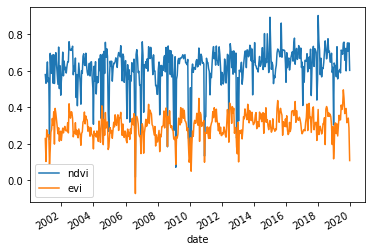

In [30]:
sub_df[['ndvi','evi']].plot()

### Low quality values

We can see that there are a lot of abnormal values or outliers.
Thus, we need to filter them ased on the QA column. 

There are two strategies to process these low quality or abnormal values

1 to remove them

2 to fill them with mean of neaby locations

### Low quality and abnormla values

In [31]:
## deal with low quality values, to keep more data for following modelling, used second strategry
def lw_process(df,cols,qual_col = "qa",strategies = "fill"):
    for col in cols:
        if strategies != "fill":
            df[col] = df[df[qual_col].notnull()][col]
        else:
            df.loc[df[qual_col].isnull(),col] = None
            ##replace with neighbours
            df[col] = (df[col].fillna(method = 'ffill') + df[col].fillna(method = 'bfill'))/2
    return df        

In [32]:
df1 = lw_process(dat,cols = ['ndvi','evi'])

In [33]:
df1.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
date,,,,,,,,,
2001-01-01,1,2001,0.580022,0.229722,1.000000,0.050433,2001-01-01,7.0,2001-01-01
2001-01-01,2,2001,0.413389,0.162797,0.545617,0.045434,2001-01-01,8.0,2001-01-01
2001-01-01,3,2001,0.376526,0.148463,0.000000,0.045796,2001-01-01,8.0,2001-01-01
2001-01-01,4,2001,0.532181,0.207942,0.000000,0.051338,2001-01-01,5.0,2001-01-01
2001-01-01,5,2001,0.719637,0.280162,0.000000,0.055572,2001-01-01,4.0,2001-01-01


In [34]:
##check the results after preprocessing to fill the low quality values
df1[df1['qa'].isnull()]

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
date,,,,,,,,,
2001-01-01,65,2001,0.711466,0.275823,NaN,0.067604,2001-01-01,7.0,2001-01-01
2001-01-01,98,2001,0.618754,0.240521,NaN,0.074681,2001-01-01,9.0,2001-01-01
2001-01-01,131,2001,0.587112,0.232783,NaN,0.084101,2001-01-01,9.0,2001-01-01
2001-01-01,450,2001,0.552984,0.289580,NaN,0.081269,2001-01-01,9.0,2001-01-01
2001-01-01,451,2001,0.552984,0.289580,NaN,0.077006,2001-01-01,9.0,2001-01-01
...,...,...,...,...,...,...,...,...,...
2019-12-19,1020,2019,0.510744,0.170990,NaN,0.057612,2019-12-19,NaN,NaN
2019-12-19,1050,2019,0.573083,0.189842,NaN,0.063258,2019-12-19,NaN,NaN
2019-12-19,1051,2019,0.573083,0.189842,NaN,0.065435,2019-12-19,NaN,NaN


In [35]:
## original data 
dat2[dat2['qa'].isnull()]

,pixel,year,ndvi,evi,qa,lai,land_cover,lc_time
time,,,,,,,,
2001-01-01,65,2001,0.690066,0.259516,NaN,0.067604,7.0,2001-01-01
2001-01-01,98,2001,0.669664,0.315819,NaN,0.074681,9.0,2001-01-01
2001-01-01,131,2001,0.619128,0.283310,NaN,0.084101,9.0,2001-01-01
2001-01-01,450,2001,0.561985,0.293409,NaN,0.081269,9.0,2001-01-01
2001-01-01,451,2001,0.543720,0.254845,NaN,0.077006,9.0,2001-01-01
...,...,...,...,...,...,...,...,...
2019-12-19,1020,2019,0.181339,0.149335,NaN,0.057612,NaN,NaN
2019-12-19,1050,2019,0.473344,0.257839,NaN,0.063258,NaN,NaN
2019-12-19,1051,2019,0.407118,0.226752,NaN,0.065435,NaN,NaN


In [36]:
sub_ndf1 = dat

In [37]:
sub_ndf1.head()

,pixel,year,ndvi,evi,qa,lai,time,land_cover,lc_time
date,,,,,,,,,
2001-01-01,1,2001,0.580022,0.229722,1.000000,0.050433,2001-01-01,7.0,2001-01-01
2001-01-01,2,2001,0.413389,0.162797,0.545617,0.045434,2001-01-01,8.0,2001-01-01
2001-01-01,3,2001,0.376526,0.148463,0.000000,0.045796,2001-01-01,8.0,2001-01-01
2001-01-01,4,2001,0.532181,0.207942,0.000000,0.051338,2001-01-01,5.0,2001-01-01
2001-01-01,5,2001,0.719637,0.280162,0.000000,0.055572,2001-01-01,4.0,2001-01-01


## LSTM

### Data formatting

In [65]:
import numpy as np
##When our feature is one dimension
def to_sequences_1D (seq_size,obs,step=1):
    x = []
    y = []

    for i in range(0,len(obs)-SEQUENCE_SIZE,step):
        '''
        seq_size: the number of observations will be used for training
        step: the change of observations to form a new training data
        obs: the whole dataset
        '''
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [44]:
## the follwoing function is more general which can deal with multiple dimensions

def to_sequences_MD (seq_size,obs,xcols,ycol,step=1):
    x = []
    y = []
    y_time = []
    for i in range(0,len(obs)-SEQUENCE_SIZE,step):
        '''
        seq_size: the number of observations will be used for training
        step: the change of observations to form a new training data
        obs: the whole dataset
        '''
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)][xcols]
        after_window = obs[(i+SEQUENCE_SIZE -1):(i+SEQUENCE_SIZE)][ycol]
        #window = [[x] for x in window]
        time_index = after_window.index.values[0]
        win_values = window.values
        #print("{} - {}".format(window,after_window))
        x.append(win_values)
        y.append(after_window.values)
        y_time.append(time_index)
        
    return np.array(x),np.array(y),y_time

In [39]:
df = df1[df1['pixel'].isin(sel_pixels) ]
df['pixel'].nunique()

209

In [40]:
## our target is ndvi, the ndvi and lai will used for external variables

##about 20 years data and 0.8 for training, thus set date 2016

SEQUENCE_SIZE = 10
sel_date= "2016-01-01"
val_pixel = df['pixel'].nunique() - 9 ##hold out data threshold threshold

In [41]:
pixel_thres = sel_pixels[val_pixel]

In [64]:
xcol = ['evi']
ycol = ['evi']

### train and test split

In [65]:
df_x_train =[]
df_x_test =[]
df_y_train =[]
df_y_test =[]

val_x_train =[]
val_x_test =[]
val_y_train =[]
val_y_test =[]

for pixel in sel_pixels:
    
    sub_df = df[df['pixel'] == pixel]
    sub_train = sub_df[sub_df.index < sel_date]
    sub_test = sub_df[sub_df.index >= sel_date ]
    
    x_train,y_train,train_time = to_sequences_MD(SEQUENCE_SIZE,sub_train, xcols =xcol,ycol=ycol)
    x_test,y_test,test_time = to_sequences_MD(SEQUENCE_SIZE,sub_test, xcols =xcol,ycol=ycol)
    
    if pixel <= pixel_thres:
        
        df_x_train.append(x_train)
        df_x_test.append(x_test)
    
        df_y_train.append(y_train)
        df_y_test.append(y_test)
        
    else:
        val_x_train.append(x_train)
        val_x_test.append(x_test)
    
        val_y_train.append(y_train)
        val_y_test.append(y_test)
    
## convert to np array

df_x_train1 = np.asarray(df_x_train).reshape(-1,SEQUENCE_SIZE,len(xcol))
df_x_test1 = np.asarray(df_x_test).reshape(-1,SEQUENCE_SIZE,len(xcol))

df_y_train1 = np.asarray(df_y_train).reshape(-1,1)
df_y_test1 = np.asarray(df_y_test).reshape(-1,1)

##hold out data
val_x_train1 = np.asarray(val_x_train).reshape(-1,SEQUENCE_SIZE,len(xcol))
val_x_test1 = np.asarray(val_x_test).reshape(-1,SEQUENCE_SIZE,len(xcol))

val_y_train1 = np.asarray(val_y_train).reshape(-1,1)
val_y_test1 = np.asarray(val_y_test).reshape(-1,1)



print("Shape of x training set: {}".format(df_x_train1.shape))
print("Shape of y training set: {}".format(df_y_train1.shape))


print("Shape of x hold out set: {}".format(val_x_train1.shape))
print("Shape of y hold out set: {}".format(val_y_train1.shape))

Shape of x training set: (67335, 10, 1)
Shape of y training set: (67335, 1)
Shape of x hold out set: (2680, 10, 1)
Shape of y hold out set: (2680, 1)


### Model building - 1D

In [77]:
model = Sequential()
model.add(LSTM(128, dropout=0.3, return_sequences= True,input_shape=(None, 1)))
model.add(LSTM(32, return_sequences=False, dropout=0.3))
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(df_x_train1,df_y_train1,validation_data=(df_x_test1,df_y_test1),
          callbacks=[monitor],
          verbose=2,epochs=30)

Train...
Train on 67335 samples, validate on 16482 samples
Epoch 1/30
67335/67335 - 39s - loss: 0.0070 - val_loss: 0.0111
Epoch 2/30
67335/67335 - 34s - loss: 0.0040 - val_loss: 0.0128
Epoch 3/30
67335/67335 - 34s - loss: 0.0036 - val_loss: 0.0133
Epoch 4/30
67335/67335 - 34s - loss: 0.0033 - val_loss: 0.0154
Epoch 5/30
67335/67335 - 34s - loss: 0.0028 - val_loss: 0.0115
Epoch 6/30
67335/67335 - 34s - loss: 0.0028 - val_loss: 0.0120
Epoch 7/30
67335/67335 - 34s - loss: 0.0027 - val_loss: 0.0135
Epoch 8/30
67335/67335 - 34s - loss: 0.0026 - val_loss: 0.0140
Epoch 9/30
67335/67335 - 35s - loss: 0.0026 - val_loss: 0.0132
Epoch 10/30
67335/67335 - 34s - loss: 0.0025 - val_loss: 0.0177
Epoch 11/30
67335/67335 - 35s - loss: 0.0025 - val_loss: 0.0135
Epoch 12/30
67335/67335 - 34s - loss: 0.0024 - val_loss: 0.0166
Epoch 13/30
67335/67335 - 34s - loss: 0.0025 - val_loss: 0.0130
Epoch 14/30
67335/67335 - 34s - loss: 0.0024 - val_loss: 0.0148
Epoch 15/30
67335/67335 - 34s - loss: 0.0024 - val_los

In [78]:
from sklearn import metrics

pred = model.predict(val_x_train1)
score = np.sqrt(metrics.mean_squared_error(pred,val_y_train1))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.13040590549737704


In [73]:
# we have 8 pixels in hold out data. each one will have 335 time interval

In [79]:
output = pd.DataFrame({"pred":pred.ravel(),
              "test":val_y_train1.ravel()})

In [80]:
output1 = output.loc[:335,]

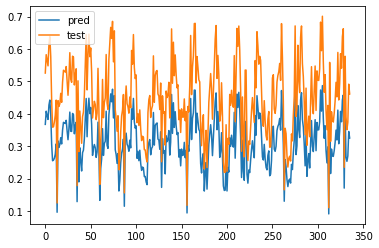

In [81]:
output1.plot()

In [58]:
pixel=1

In [59]:
sub_df1 = df[df['pixel'] == pixel]
sub_train1 = sub_df1[sub_df1.index < sel_date]

In [63]:
sub_train1.shape

(345, 9)

## 2.2 Predicition on data quality using NDVI and EVI - regression

In [87]:
##Based on previous exploration, we know that pixel = 464 is best location for us to explore

df2 = dat2[dat2['pixel'] == sel_pixel[0]]
df2.sort_index(inplace = True)

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [70]:
df2.head()

,pixel,year,ndvi,evi,qa,land_cover,lc_time
time,,,,,,,
2001-01-01,464,2001,0.510641,0.287295,1.0,8.0,2001-01-01
2001-01-17,464,2001,0.457637,0.162410,1.0,8.0,2001-01-01
2001-02-02,464,2001,0.553835,0.315182,0.0,8.0,2001-01-01
2001-02-18,464,2001,0.079125,0.101180,2.0,8.0,2001-01-01
2001-03-06,464,2001,0.522178,0.280573,0.0,8.0,2001-01-01


## Data preparation

In [105]:
##if our data is >2 dimension, we are interested in predicting the 
def to_sequences_MD (seq_size,obs,xcols,ycol,step=1):
    x = []
    y = []
    y_time = []
    for i in range(0,len(obs)-SEQUENCE_SIZE,step):
        '''
        seq_size: the number of observations will be used for training
        step: the change of observations to form a new training data
        obs: the whole dataset
        '''
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)][xcols]
        after_window = obs[(i+SEQUENCE_SIZE -1):(i+SEQUENCE_SIZE)][ycol]
        #window = [[x] for x in window]
        time_index = after_window.index.values[0]
        win_values = window.values
        #print("{} - {}".format(window,after_window))
        x.append(win_values)
        y.append(after_window.values)
        y_time.append(time_index)
        
    return np.array(x),np.array(y),y_time

In [98]:
df_train2.head(11)

,pixel,year,ndvi,evi,qa,land_cover,lc_time
time,,,,,,,
2001-01-01,464,2001,0.510641,0.287295,1.0,8.0,2001-01-01
2001-01-17,464,2001,0.457637,0.162410,1.0,8.0,2001-01-01
2001-02-02,464,2001,0.553835,0.315182,0.0,8.0,2001-01-01
2001-02-18,464,2001,0.079125,0.101180,2.0,8.0,2001-01-01
2001-03-06,464,2001,0.522178,0.280573,0.0,8.0,2001-01-01
2001-03-22,464,2001,0.570117,0.342850,0.0,8.0,2001-01-01
2001-04-07,464,2001,0.648065,0.475009,3.0,8.0,2001-01-01
2001-04-23,464,2001,0.668908,0.390804,1.0,8.0,2001-01-01
2001-05-09,464,2001,0.487433,0.284394,0.0,8.0,2001-01-01


In [103]:
after_win =df_train2[9:10]['qa']

In [104]:
after_win.index.values[0]

'2001-05-25'

### Train and test split

In [106]:
##about 20 years data and 0.8 for training
sel_date= "2016-01-01"
df_train2 = df2[df2.index < sel_date ]
df_test2 = df2[df2.index >= sel_date ]

In [107]:
SEQUENCE_SIZE = 10
x_train2,y_train2,train_index = to_sequences_MD(SEQUENCE_SIZE,df_train2,xcols=['ndvi','evi'],ycol = ['qa'])
x_test2,y_test2,test_index = to_sequences_MD(SEQUENCE_SIZE,df_test2,xcols=['ndvi','evi'],ycol = ['qa'])

print("Shape of training set: {}".format(x_train2.shape))
print("Shape of test set: {}".format(x_test2.shape))

Shape of training set: (335, 10, 2)
Shape of test set: (82, 10, 2)


In [84]:
y_train21 = y_train2.reshape((y_train2.shape[0],))
y_test21 = y_test2.reshape((y_test2.shape[0],))

In [86]:
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 2)))##here also need to change
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train2,y_train21,validation_data=(x_test2,y_test21),callbacks=[monitor],verbose=2,epochs=1000)

Train...
Train on 335 samples, validate on 82 samples
Epoch 1/1000
335/335 - 3s - loss: 0.8810 - val_loss: 0.7251
Epoch 2/1000
335/335 - 0s - loss: 0.6879 - val_loss: 0.7244
Epoch 3/1000
335/335 - 0s - loss: 0.6673 - val_loss: 0.7378
Epoch 4/1000
335/335 - 0s - loss: 0.6629 - val_loss: 0.7236
Epoch 5/1000
335/335 - 0s - loss: 0.6529 - val_loss: 0.7191
Epoch 6/1000
335/335 - 0s - loss: 0.6455 - val_loss: 0.7170
Epoch 7/1000
335/335 - 0s - loss: 0.6397 - val_loss: 0.7155
Epoch 8/1000
335/335 - 0s - loss: 0.6314 - val_loss: 0.7101
Epoch 9/1000
335/335 - 0s - loss: 0.6183 - val_loss: 0.7072
Epoch 10/1000
335/335 - 0s - loss: 0.6055 - val_loss: 0.6992
Epoch 11/1000
335/335 - 0s - loss: 0.6068 - val_loss: 0.7102
Epoch 12/1000
335/335 - 0s - loss: 0.5895 - val_loss: 0.6929
Epoch 13/1000
335/335 - 0s - loss: 0.5844 - val_loss: 0.6950
Epoch 14/1000
335/335 - 0s - loss: 0.5696 - val_loss: 0.6925
Epoch 15/1000
335/335 - 0s - loss: 0.5717 - val_loss: 0.7211
Epoch 16/1000
335/335 - 0s - loss: 0.562

In [127]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
pred2 = model.predict(x_test2)
score = np.sqrt(metrics.mean_squared_error(pred2,y_test21))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.832413255469476


In [113]:
### as we know that the good quality points should be within [0,1], we can classify them into good or not good
output = pd.DataFrame({"pred":pred2.ravel(),
              "test":y_test21.ravel()},index = test_index)


In [114]:
output.head()

,pred,test
2016-05-24,0.731439,1.0
2016-06-09,0.666747,3.0
2016-06-25,0.578940,1.0
2016-07-11,0.529566,0.0
2016-07-27,0.584527,3.0


In [117]:
min(dat2['qa'].min(), -0.0003)

-6

In [120]:
bins = [min(dat2['qa'].min(), -0.0003),1.0001,dat2['qa'].max()]
names = ['yes','no']

output['pred_class'] = pd.cut(output['pred'],bins,labels = names)
output['test_class'] = pd.cut(output['test'],bins,labels = names)

In [142]:
cm = confusion_matrix(output['test_class'], output['pred_class'],labels=['yes','no'])

In [145]:
cm

array([[75,  0],
       [ 7,  0]], dtype=int64)

In [131]:
pred_class = pd.get_dummies(output['pred_class'])

In [138]:
correct = accuracy_score(output['pred_class'],output['test_class'])
print(f"Accuracy: {correct}")

Accuracy: 0.9146341463414634


### Summary

We can see we can only can detect good quality, but caanot predict low quality.

There are several reasons for this:

    1 imblance data
    
    2 not enough data for LSTM
    
    3 There is no connection between the ndvi,evi and quality. We cannot assess the value quality based on these variables
    

## 2.3 Predicition on data quality using NDVI and EVI - classification
Classify y (qa) into yes (good quality) and no (low quality)

In [146]:
df3 = dat2[dat2['pixel'] == sel_pixel[0]]
df3.sort_index(inplace = True)

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [162]:
bins = [min(df3['qa'].min()-0.01, -0.000001),1.0001,df3['qa'].max()]
names = ['yes','no']

df3['quality'] = pd.cut(df3['qa'],bins,labels = names)

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## data format (still use the function in 2.2)

In [163]:
##about 20 years data and 0.8 for training
sel_date= "2016-01-01"
df_train3 = df3[df3.index < sel_date ]
df_test3 = df3[df3.index >= sel_date ]

In [164]:
df_train3.head()

,pixel,year,ndvi,evi,qa,land_cover,lc_time,quality
time,,,,,,,,
2001-01-01,464,2001,0.510641,0.287295,1.0,8.0,2001-01-01,yes
2001-01-17,464,2001,0.457637,0.162410,1.0,8.0,2001-01-01,yes
2001-02-02,464,2001,0.553835,0.315182,0.0,8.0,2001-01-01,yes
2001-02-18,464,2001,0.079125,0.101180,2.0,8.0,2001-01-01,no
2001-03-06,464,2001,0.522178,0.280573,0.0,8.0,2001-01-01,yes


In [165]:
SEQUENCE_SIZE = 10
x_train3,y_train3,train_index = to_sequences_MD(SEQUENCE_SIZE,df_train3,xcols=['ndvi','evi'],ycol = ['quality'])
x_test3,y_test3,test_index = to_sequences_MD(SEQUENCE_SIZE,df_test3,xcols=['ndvi','evi'],ycol = ['quality'])

print("Shape of training set: {}".format(x_train2.shape))
print("Shape of test set: {}".format(x_test2.shape))

Shape of training set: (335, 10, 2)
Shape of test set: (82, 10, 2)


In [166]:
y_train31 = y_train3.reshape((y_train3.shape[0],))
y_test31 = y_test3.reshape((y_test3.shape[0],))

In [179]:
y_train32 = pd.get_dummies(pd.DataFrame(y_train31)).values
y_test32 = pd.get_dummies(pd.DataFrame(y_test31)).values

In [171]:
num_class = x_train3.shape[2]

In [182]:
model = Sequential()
model.add(LSTM(128, input_shape=(None, num_class)))
model.add(Dense(num_class, activation='softmax'))

#optimizer = RMSprop(lr=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)
             
model.compile(loss='binary_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train3,y_train32,validation_data=(x_test3,y_test32),callbacks=[monitor],verbose=2,epochs=1000)

Train...
Train on 335 samples, validate on 82 samples
Epoch 1/1000
335/335 - 3s - loss: 0.4833 - val_loss: 0.2965
Epoch 2/1000
335/335 - 0s - loss: 0.3148 - val_loss: 0.2968
Epoch 3/1000
335/335 - 0s - loss: 0.3039 - val_loss: 0.2922
Epoch 4/1000
335/335 - 0s - loss: 0.3000 - val_loss: 0.2913
Epoch 5/1000
335/335 - 0s - loss: 0.2968 - val_loss: 0.2907
Epoch 6/1000
335/335 - 0s - loss: 0.2978 - val_loss: 0.2888
Epoch 7/1000
335/335 - 0s - loss: 0.2934 - val_loss: 0.2883
Epoch 8/1000
335/335 - 0s - loss: 0.2858 - val_loss: 0.2859
Epoch 9/1000
335/335 - 0s - loss: 0.2846 - val_loss: 0.2844
Epoch 10/1000
335/335 - 0s - loss: 0.2828 - val_loss: 0.2828
Epoch 11/1000
335/335 - 0s - loss: 0.2740 - val_loss: 0.2830
Epoch 12/1000
335/335 - 0s - loss: 0.2782 - val_loss: 0.2840
Epoch 13/1000
335/335 - 0s - loss: 0.2659 - val_loss: 0.2967
Epoch 14/1000
335/335 - 0s - loss: 0.2686 - val_loss: 0.2801
Epoch 15/1000
335/335 - 0s - loss: 0.2604 - val_loss: 0.3219
Epoch 16/1000
335/335 - 0s - loss: 0.269

In [184]:
pred = model.predict(x_test3)

In [185]:
score = metrics.log_loss(y_test32, pred)
print("Log loss score: {}".format(score))

Log loss score: 0.26535736359996587


In [187]:
##evaulation FOR CLASSIFICATION
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test32,axis=1)

In [188]:
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

Accuracy: 0.9146341463414634


In [189]:
confusion_matrix(expected_classes,predict_classes)

array([[ 0,  7],
       [ 0, 75]], dtype=int64)

## Summary

Please look at section 2.2